установим необходимые модули

In [8]:
pip install -U gigachain-core gigachain-community gigachain-openai gigachain gigagraph ipython

Note: you may need to restart the kernel to use updated packages.


объявим некоторые переменные
GIGACHAT_CREDENTIALS - креды для GigaChat. Можно получить на developers.sber.ru
GIGACHAT_SCOPE - возможны варианты GIGACHAT_API_PERS/GIGACHAT_API_CORP/GIGACHAT_API_B2B
GIGACHAT_MODEL - тип модели. Возможные варианты GigaChat-Pro/GigaChat/GigaChat-Plus

In [9]:
import os

%env GIGACHAT_CREDENTIALS=MTAzZDcwZmItNWFjMS00NjMyLWEzMmUtYzk3YjdiOWM4NjI0OjUxOGQ3ZjZmLTRkMTEtNGQxMS05ZTVmLTI1MTEzMmQ4YjIyZg==
%env GIGACHAT_SCOPE=GIGACHAT_API_PERS 
%env GIGACHAT_MODEL=GigaChat-Pro


env: GIGACHAT_CREDENTIALS=MTAzZDcwZmItNWFjMS00NjMyLWEzMmUtYzk3YjdiOWM4NjI0OjUxOGQ3ZjZmLTRkMTEtNGQxMS05ZTVmLTI1MTEzMmQ4YjIyZg==
env: GIGACHAT_SCOPE=GIGACHAT_API_PERS
env: GIGACHAT_MODEL=GigaChat-Pro


Создадим класс для хранения состояния графа

In [10]:
from typing import Dict

from typing_extensions import TypedDict


class GraphState(TypedDict):
    args: Dict
    question: str
    generation: str
    context: str

Создание роута для классификации вопроса

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from pydantic import BaseModel, Field
from langchain_community.chat_models import GigaChat

creds = "MTAzZDcwZmItNWFjMS00NjMyLWEzMmUtYzk3YjdiOWM4NjI0OjUxOGQ3ZjZmLTRkMTEtNGQxMS05ZTVmLTI1MTEzMmQ4YjIyZg=="


class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    qtype: Literal["info_clinic", "appointment", "info_doctor", "info_free_date"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

  
system = """
Твоя задача соотнести вопрос пользователя с одной из категорий:
1. appointment - Запись на приём к врачу \n
2. info_free_date - Вопрос про свободное время у врача \n
3. info_doctor - Список врачей \n
4. info_clinic - Список клиник \n
В ответ написать к какой категории относится вопрос
"""

chat = GigaChat(
    model="GigaChat-Pro",
    credentials=creds,
    scope= "GIGACHAT_API_PERS",
    verify_ssl_certs=False,

    temperature=0.1
)

structured_llm_router = chat.with_structured_output(RouteQuery)
type_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: {question}"),
    ]
)

categorize_llm = type_prompt | structured_llm_router

print(categorize_llm.invoke({"question": "Какое время свободно 3 сентября у Колесникова?"}))
print(categorize_llm.invoke({"question": "Какие есть хирурги?"}))
print(categorize_llm.invoke({"question": "У какого хирурга есть свободное время на 3 сентября?"}))
print(categorize_llm.invoke({"question": "Запиши на прием к Колесникову на 3 сентября 10:00"}))



{'qtype': 'info_free_date'}
{'qtype': 'info_doctor'}
{'qtype': 'info_free_date'}
{'qtype': 'appointment'}


Функция для роута

In [12]:
def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = categorize_llm.invoke({"question": question})
    print(source)
    if source['qtype'] == "info_clinic":
        print("---ROUTE QUESTION TO INFO CLINIC---")
        return "info_clinic"
    elif source['qtype'] == "appointment":
        print("---ROUTE QUESTION TO APPOINTMENT---")
        return "appointment"
    elif source['qtype'] == "info_doctor":
        print("---ROUTE QUESTION TO INFO DOCTOR---")
        return "info_doctor"
    elif source['qtype'] == "info_free_date":
        print("---ROUTE QUESTION TO INFO FREE DATE---")
        return "info_free_date"

Поиск данных на dataspace

In [23]:
from langchain_community.utilities.requests import TextRequestsWrapper


def find_doctors(state):
    question = state['question']
    
    graphql_search_doctors = {
            "operationName": "searchDoctors",
            "variables": {},
            "query": "query searchDoctors {\n  searchClinic {\n    elems {\n      clinicDoctorList {\n        elems {\n          clinic {\n            name\n          }\n          doctor {\n            entityId\n            entity {\n              person {\n                entityId\n                entity {\n                  lastName\n                }\n              }\n              doctorType {\n                name\n              }\n            }\n          }\n        }\n      }\n    }\n  }\n}\n"
        }
    
    requests_tool = TextRequestsWrapper()

    # Use the tool
    response = requests_tool.post(url="https://smapi.pv-api.sbc.space/ds-7429590172239724545/graphql", data=graphql_search_doctors)
    print(response)
    return { "question": question, "context": response }
                            
    #добавил эту функцию
def find_clinics(state):
    question = state['question']
    
    graphql_search_clinics = {
            "operationName": "searchClinics",
            "variables": {},
            "query": "query searchClinics {\n  searchClinic {\n    elems {\n      name\n      clinicTableList {\n        elems {\n   endDate\n          beginDate\nclinicOffice{\nofficeNumber\n         }\n        }\n      }\n    }\n  }\n}"
        }
    
    requests_tool = TextRequestsWrapper()

    # Use the tool
    response = requests_tool.post(url="https://smapi.pv-api.sbc.space/ds-7429590172239724545/graphql", data=graphql_search_clinics)
    print(response)
    return { "question": question, "context": response }


def find_info_free_date(state):
    question = state['question']

    graphql_search_availability = {
            "operationName": "searchClinicDoctorAvailability",
            "variables": {''},
            "query": ""
        }
    


# эти функции надо будет сделать и подсоединить их
#надо обработать 4 типа запросов:
#{'qtype': 'info_free_date'} - дан в исходном документе
#{'qtype': 'info_doctor'} - я добавил
#{'qtype': 'info_free_date'} - надо добавить обработку
#{'qtype': 'appointment'} - надо добавить (тут нужно сделать миграцию(запись и проверка, что на это время еще нет записи))
def find_free_time_of_doctor():
    pass

def find_doctor_by_id():
    pass

def find_available_appointment():
    pass

def write_appointment():
    pass


# Print the response


Функция по генерации ответа пользователю

In [14]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser


# Prompt
system = """
Твоя задача ответить на вопрос, используя информацию из {context}.
{context} представляет из себя результат запроса к внешнему ресурсу в формате json
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: {question}"),
    ]
)

giga = GigaChat(
    model="GigaChat-Pro",
    credentials=creds,
    scope= "GIGACHAT_API_PERS",
    verify_ssl_certs=False,

    temperature=0.1
)

# Chain
chain = prompt | giga | StrOutputParser()

# Run (это пример, какой запрос выходит в итоге ИЗ graphQL)
test_context='{"data":{"searchClinic":{"elems":[{"clinicDoctorList":{"elems":[{"clinic":{"name":"Клиника N1"},"doctor":{"entityId":"7424408113957502977","entity":{"person":{"entityId":"7424406473279995905","entity":{"lastName":"Biryukov"}},"doctorType":{"name":"Терапевт"}}}},{"clinic":{"name":"Клиника N1"},"doctor":{"entityId":"7424408113957502979","entity":{"person":{"entityId":"7424406477574963202","entity":{"lastName":"Varenikov"}},"doctorType":{"name":"Хирург"}}}}]}}]}}}'

generation = chain.invoke({"context": test_context, "question": "Какие есть хирурги?"})
print(generation)
generation = chain.invoke({"context": test_context, "question": "Какие есть терапевты?"})
print(generation)

# на основе json'a из graphql формируется ответ
def generate(state):

    print("---GENERATE---")
    question = state["question"]
    context = state["context"]

    # RAG generation
    generation = chain.invoke({"context": context, "question": question})
    return {"context": context, "question": question, "generation": generation}


В клинике N1 работает хирург по имени Varenikov.
В клинике "Клиника N1" работают два терапевта с фамилиями Biryukov и Varenikov.


Формируем worflow

In [22]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

#TODO
workflow.add_node("info_doctor", find_doctors)
#добавил строку
#сюда добавьте еще результаты работы других функций (write_appointment и др.)
workflow.add_node("info_clinic", find_clinics)

workflow.add_node("generate", generate)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "info_doctor": "info_doctor",
        # добавил эту строку о клинике
        "info_clinic" : "info_clinic"
    },
)

workflow.add_edge("info_doctor", "generate")
#добавил эту строку - это для графа, хз зачем оно
workflow.add_edge("info_clinic", "generate")

app = workflow.compile()

Посмотрим, какой получился граф

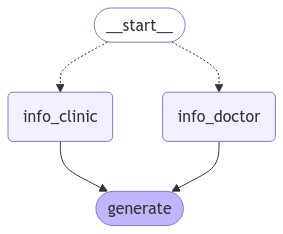

In [19]:
from IPython.display import Image, display
import traceback
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as ex:
    traceback.format_exc()
    # This requires some extra dependencies and is optional
    pass

In [20]:
from pprint import pprint

# Run (ПРОВЕРКА РАБОТА - СЮДА КИДАЕМ ТЕСТОВЫЙ ЗАПРОС)
inputs = {
    "question": "Какие есть доктора?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        #pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
{'qtype': 'info_clinic'}
---ROUTE QUESTION TO INFO CLINIC---
{"data":{"searchClinic":{"elems":[{"name":"Клиника N1","clinicTableList":{"elems":[]}},{"name":"Клиника №2","clinicTableList":{"elems":[]}}]}}}
"Node 'info_clinic':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
'В наличии две клиники: Клиника N1 и Клиника №2.'
